CS5010 FINAL PROJECT

Group 8 | Allison Hansen (Aph7hy), Amanda Maruca (qfu2fy), Colin Warner (ynq9ya)

TOPIC | Refugee Resettlement/Asylum Seeking Data

## NOTES: 

User can select a country from either top 10 bar charts provided 

maybe our goal is like learn about world refugees based on top 10 countries of origin and asylum in the world and then we show the bar charts 

User will be provided with the following stats based on selection 
: these might need to be different depending on if the user selects a top 10 country of origin vs asylum 

- percent of refugees/applications country is responsible for 
- how many different countries people seek asylum to 
- top 5 aslyum countries from origin or top 5 origin to asylum 
- demographic data (amanda)
- some time series trend line --> percentage of accepted over time (allison)
- map (colin)

In [ ]:
# imports

import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import geopandas 
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer
import json

In [ ]:
# mount google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Read in Data Files 

I added each file to my drive, not under any specific folder and then run this code to read in the files 

In [ ]:
file = '/content/drive/MyDrive/asylum-decisions.csv'
data = pd.read_csv(file)

df_decisions = pd.DataFrame(data)

In [ ]:
file = '/content/drive/MyDrive/asylum-applications.csv'
data = pd.read_csv(file)

df_applications = pd.DataFrame(data)

In [ ]:
file = '/content/drive/MyDrive/demographics.csv'
data = pd.read_csv(file)

df_demographics = pd.DataFrame(data)

In [ ]:
### ASYLUM DECISIONS DATA SET FROM UNHCR ###

#fill blank country of origin codes with unk to represent unknown
df_decisions = df_decisions.fillna("UNK")

#create unique id field concatenating year, and both country ISO's. To be used for joins later.
df_decisions['id'] = df_decisions['Year'].map(str) + "-" + df_decisions['Country of origin (ISO)'].map(str) + "-" + df_decisions['Country of asylum (ISO)'].map(str)

#group by id, year, country of origin, and country of asylum (plus their ISO's) in order to get sums of decision columns per unique country combination of origin-asylum 
df_decisions = df_decisions.groupby(['id','Year','Country of origin','Country of origin (ISO)', 'Country of asylum', 'Country of asylum (ISO)'])['Recognized decisions','Complementary protection', 'Rejected decisions', 'Otherwise closed', 'Total decisions'].sum()

#print this result to a csv file to be read back in later.
#note: this is the only way i found to 'trick' pandas into allowing me to join by the group by columns later. i use this trick throughout the file. 
df_decisions.to_csv(r'df_decisions.csv')

print("total rows in df_decisions:")
print(df_decisions.shape[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # Remove the CWD from sys.path while we load stuff.


total rows in df_decisions:
59306


In [ ]:
### ASYLUM APPLICATIONS DATA SET FROM UNHCR ###

#fill blank country of origin codes with unk to represent unknown
df_applications = df_applications.fillna("UNK")

# create unique id field concatenating year, and both country ISO's. To be used for joins later.
df_applications['id'] = df_applications['Year'].map(str) + "-" + df_applications['Country of origin (ISO)'].map(str) + "-" + df_applications['Country of asylum (ISO)'].map(str)

# group by id, year, country of origin, and country of asylum (plus their ISO's) in order to get sums of applications per unique country combination of origin-asylum 
df_applications = df_applications.groupby(['id','Year','Country of origin','Country of origin (ISO)', 'Country of asylum', 'Country of asylum (ISO)'])['applied'].sum()

# print this result to a csv file to be read back in later.
df_applications.to_csv(r'df_applications.csv')
print("total rows in df_applications:")
print(df_applications.shape[0])

total rows in df_applications:
66113


In [ ]:
# read back in the df_decisions csv from before in order to join with df_applications on id
df_decisions = pd.read_csv("df_decisions.csv")

# read back in the df_applications csv from before in order to join with df_decisions on id
df_applications = pd.read_csv("df_applications.csv")

In [ ]:
# Inner join the decisions and applications files on previously created id field. 
# add suffix to commonly named fields in order to distinguish which file they are coming from. 
df_dec_app = df_applications.set_index('id').join(df_decisions.set_index('id'), lsuffix='_applications', rsuffix='_decisions', how='inner')

In [ ]:
# print this result to a csv file to be read back in later.
df_dec_app.to_csv(r'df_dec_app.csv')

In [ ]:
# read back in the df_dec_app csv from before in order to join with new df_demographics on id
df_dec_app = pd.read_csv("df_dec_app.csv")
print("total rows in df_dec_app:")
print(df_dec_app.shape[0])

total rows in df_dec_app:
53288


In [ ]:
### DEMOGRAPHIC DATA SET FROM UNHCR ###

#fill blank country of origin codes with unk to represent unknown
df_demographics = df_demographics.fillna("UNK")
# create unique id field concatenating year, and both country ISO's. To be used for joins later.
df_demographics['id'] = df_demographics['Year'].map(str) + "-" + df_demographics['Country of origin (ISO)'].map(str) + "-" + df_demographics['Country of asylum (ISO)'].map(str)
print("total rows in df_demographics:")
print(df_demographics.shape[0])

total rows in df_demographics:
62447


In [ ]:
### ALL DATA SETS FROM UNHCR ###

# Inner join the df_dc_app and df_demographics files on previously created id field. 
df_joined = df_dec_app.set_index('id').join(df_demographics.set_index('id'), rsuffix="_demos", how="inner")

# print this result to a csv file. this is the complete aggregated file for our original UNHCR Data Source
df_joined.to_csv(r'df_joined.csv')
print("total rows in df_joined:")
print(df_joined.shape[0])

# read back in the joined data set. 
df_joined = pd.read_csv("df_joined.csv")





total rows in df_joined:
34760


In [ ]:
### GROUP BY COUNTRY OF ORIGIN, SORT BY TOTAL APPLICATIONS###

df_origin = df_joined.groupby(['Country of origin_applications','Country of origin (ISO)_applications'])['applied','Recognized decisions','Complementary protection','Rejected decisions','Otherwise closed', 'Total decisions'].sum().reset_index()
df_origin = df_origin.sort_values('applied', ascending=False)
df_origin["total_accepted"] = df_origin["Recognized decisions"] + df_origin["Complementary protection"]
df_origin["total_rejected"] = df_origin["Rejected decisions"] + df_origin["Otherwise closed"]
df_origin["ratio_accepted"] = (df_origin["total_accepted"] / df_origin["Total decisions"])
df_origin_top10 = df_origin.head(n = 10)
df_origin_top10.to_csv(r'df_origin.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
### GROUP BY COUNTRY OF ASYLUM, SORT BY TOTAL APPLICATIONS ###

df_asylum = df_joined.groupby(['Country of asylum_applications','Country of asylum (ISO)_applications'])['applied','Recognized decisions','Complementary protection','Rejected decisions','Otherwise closed', 'Total decisions'].sum().reset_index()
df_asylum = df_asylum.sort_values('applied', ascending=False)
df_asylum["total_accepted"] = df_asylum["Recognized decisions"] + df_asylum["Complementary protection"]
df_asylum["total_rejected"] = df_asylum["Rejected decisions"] + df_asylum["Otherwise closed"]
df_asylum["ratio_accepted"] = (df_asylum["total_accepted"] / df_asylum["Total decisions"])
df_asylum_top10 = df_asylum.head(n = 10)
df_asylum_top10.to_csv(r'df_asylum.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


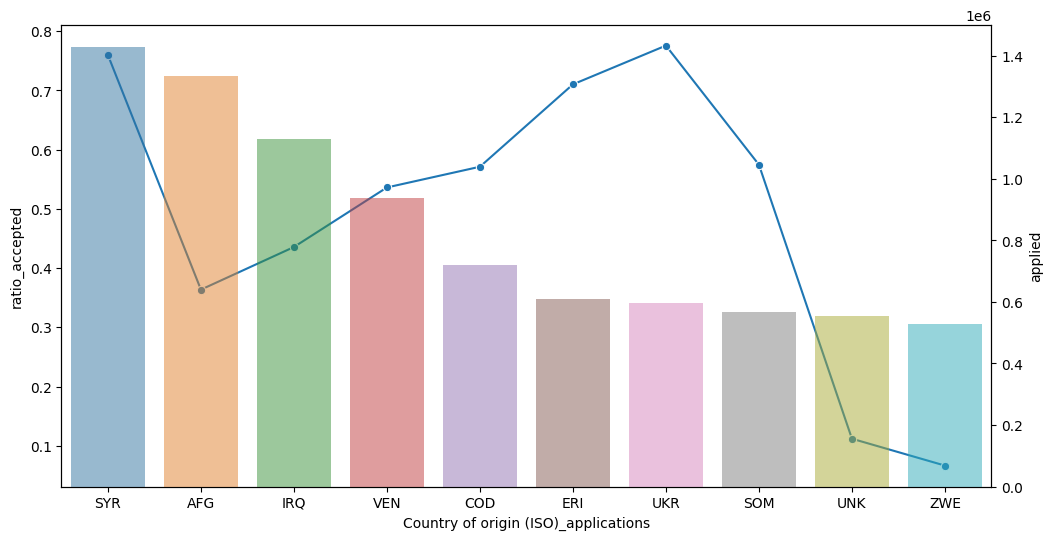

In [ ]:
### CREATE BASIC BAR PLOT OF 10 COUNTRIES WITH MOST ASYLUM SEEKERS SUBMITTING APPLICATIONS ###

matplotlib.rc_file_defaults()
ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(12,6))

sns.lineplot(data = df_origin_top10, x='Country of origin (ISO)_applications', y = 'ratio_accepted' , marker='o', sort = False, ax=ax1)
ax2 = ax1.twinx()

sns.barplot(data = df_origin_top10, x='Country of origin (ISO)_applications', y='applied', alpha=0.5, ax=ax2)

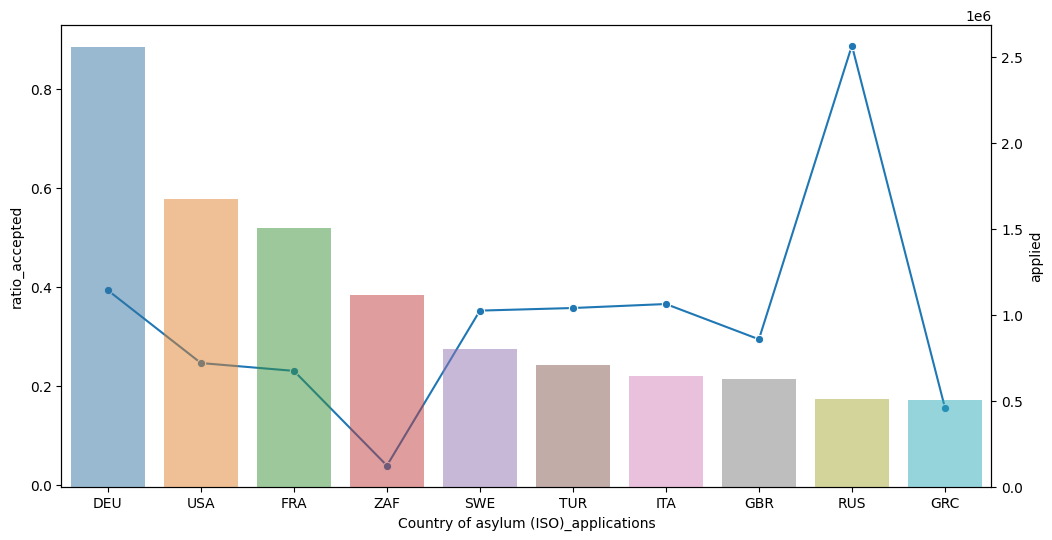

In [ ]:
### CREATE BASIC BAR PLOT OF TOP 10 COUNTRIES OF ASYLUM BY APPLICATIONS RECEIVED ###

matplotlib.rc_file_defaults()
ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(12,6))

sns.lineplot(data = df_asylum_top10, x='Country of asylum (ISO)_applications', y = 'ratio_accepted' , marker='o', sort = False, ax=ax1)
ax2 = ax1.twinx()

sns.barplot(data = df_asylum_top10, x='Country of asylum (ISO)_applications', y='applied', alpha=0.5, ax=ax2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'GDP Versus Refugee Applications')

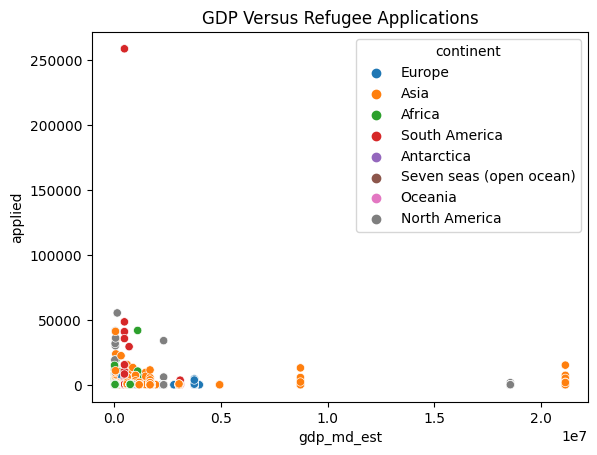

In [ ]:
country_df = df_joined.groupby(['Country of origin_applications','Country of origin (ISO)_applications','Country of asylum_applications','Country of asylum (ISO)_applications','Year'])['applied','Recognized decisions','Complementary protection','Rejected decisions','Otherwise closed', 'Total decisions'].sum().reset_index()
country_df = country_df[country_df['Year'] == 2019]
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
# world_csv = world.head(n = 10)
# world_csv.to_csv(r'world.csv')

country_df = world.set_index('iso_a3').join(country_df.set_index('Country of origin (ISO)_applications'), lsuffix='_map', rsuffix='_data', how='left')
country_df['total_accepted'] = country_df["Recognized decisions"] + country_df["Complementary protection"]
country_df['ratio_accepted'] = (country_df["total_accepted"] / country_df["Total decisions"])
scatter_plot = sns.scatterplot(y = "applied", x = "gdp_md_est", data = country_df, hue = "continent")
scatter_plot.set_title("GDP Versus Refugee Applications") #set the title of scatter plot we just created.





### FINAL PRODUCT ###

working draft 

*** you have to run all the kernel functions before you run main

 --> we might end up wanting to put them in the same kernel for the final



Welcome to our product
this product is designed to provide information about refugees around the world
to begin, view these graphs of the most common countries of origin and asylum
Please enter origin or asylum to select the type of country you would like to learn more about: origin
The top 10 country codes of world refugee countries of origin are: 
['SYR', 'AFG', 'IRQ', 'VEN', 'COD', 'ERI', 'UKR', 'SOM', 'UNK', 'ZWE']
Please enter the three digit country code of the country you would like to learn more about: VEN

You selected VEN as the country of origin.
43
5.0677635731266415
['Peru', 'United States of America', 'Brazil', 'Spain', 'Ecuador']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


AxesSubplot(0.125596,0.268664;0.773809x0.498426)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


AxesSubplot(0.125596,0.268664;0.773809x0.498426)


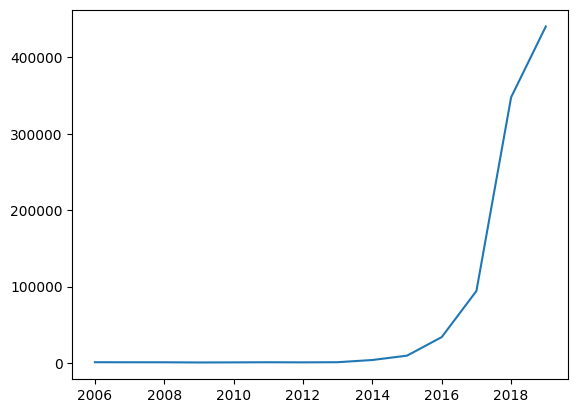

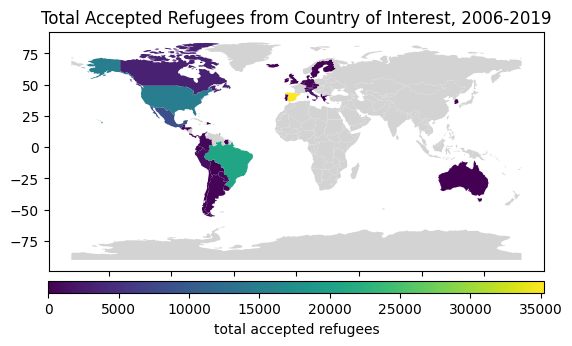

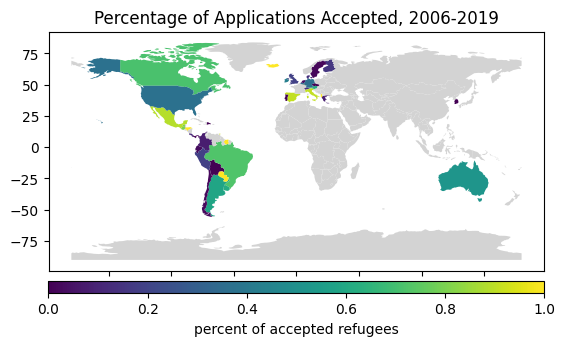

In [ ]:
def main():
    print('Welcome to our product')
    print('this product is designed to provide information about refugees around the world')
    print('to begin, view these graphs of the most common countries of origin and asylum')
    # code for bar charts here 
    # maybe also put into a function? 

    # choose country of origin or asylum 
    type = input('Please enter origin or asylum to select the type of country you would like to learn more about: ')
    # print possible country codes based on type selection
    if type == 'origin':
      print('The top 10 country codes of world refugee countries of origin are: ')
      print(df_origin_top10['Country of origin (ISO)_applications'].tolist())
    else: 
      print('The top 10 country codes of world refugee countries of asylum are: ')
      print(df_asylum_top10['Country of asylum (ISO)_applications'].tolist())
    country = input('Please enter the three digit country code of the country you would like to learn more about: ')
    print()
    # confirm selection 
    print('You selected ' + country + ' as the country of ' + type + '.')
    
    if type == 'origin': 
      country_df = df_joined.loc[df_joined['Country of origin (ISO)_applications'] == country]
      # change the prints below for better formatting 
      # could add analysis / context for why values are important 
      print(numAsylumDest(country_df))
      print(perWorldRef(country_df))
      print(top5asylum(country_df))
      print(originTimeSeries(country_df))
      print(originmap(country_df))
      print(originmapratio(country_df))
    else: 
      country_df = df_joined.loc[df_joined['Country of asylum (ISO)_applications'] == country]
      print(numOriginCont(country_df))
      print(perWorldRefAsylum(country_df))
      print(top5origin(country_df))
      print(asylumTimeSeries(country_df))
      print(asylummap(country_df))
      print(asylummapratio(country_df))

if __name__ == "__main__":
    main()

In [ ]:
# country of origin function: number of asylum destinations 

def numAsylumDest(country_df): 
  n = len(country_df['Country of asylum'].unique())
  return n

In [ ]:
# country of origin function: percentage of world refugees 

def perWorldRef(country_df): 
  country_apps = country_df['applied'].sum()
  all_apps = df_origin['applied'].sum()
  p = country_apps / all_apps
  # need to finish formatting like percentage 
  return p*100

In [ ]:
# country of origin function: top 5 countries of asylum 

def top5asylum(country_df):
  country_df.groupby(['Country of asylum_applications']).sum()  
  country_df_top = country_df.groupby(['Country of asylum_applications','Country of asylum (ISO)_applications'])['applied','Recognized decisions','Complementary protection','Rejected decisions','Otherwise closed', 'Total decisions'].sum().reset_index()
  country_df_top = country_df_top.sort_values('applied', ascending=False)
  country_df_top["total_accepted"] = country_df_top["Recognized decisions"] + country_df_top["Complementary protection"]
  country_df_top["total_rejected"] = country_df_top["Rejected decisions"] + country_df_top["Otherwise closed"]
  country_df_top["ratio_accepted"] = (country_df_top["total_accepted"] / country_df_top["Total decisions"])
  country_df_top5 = country_df_top.head(n = 5)
  country_df_top5.to_csv(r'country_df_top5.csv')
  top5 = country_df_top5['Country of asylum_applications'].tolist()
  return top5

In [ ]:
# country of origin function: time series 

def originTimeSeries(country_df):
  country_df_yr = country_df.groupby(country_df['Year_applications']).sum().reset_index()
  # need to re-format plot to be more attractive 
  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)
  plot = ax.plot(country_df_yr['Year_applications'], country_df_yr['applied'])
  return plot


In [ ]:
# country of origin accepted function: map
def originmap(country_df):
      country_df = country_df.groupby(['Country of origin_applications','Country of origin (ISO)_applications','Country of asylum_applications','Country of asylum (ISO)_applications'])['applied','Recognized decisions','Complementary protection','Rejected decisions','Otherwise closed', 'Total decisions'].sum().reset_index()
      world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
      country_df = world.set_index('iso_a3').join(country_df.set_index('Country of asylum (ISO)_applications'), lsuffix='_map', rsuffix='_data', how='left')
      country_df['total_accepted'] = country_df["Recognized decisions"] + country_df["Complementary protection"]
      country_df['ratio_accepted'] = (country_df["total_accepted"] / country_df["Total decisions"])
      from mpl_toolkits.axes_grid1 import make_axes_locatable
      fig, ax = plt.subplots(1, 1)
      divider = make_axes_locatable(ax)
      country = str(country_df['Country of origin (ISO)_applications'].iloc[0])
      title = "Total Accepted Refugees from Country of Interest, 2006-2019"
      ax.set(title=title)
      cax = divider.append_axes("bottom", size="5%", pad=0.1)
      plot1 = country_df.plot(column="total_accepted", ax=ax, legend=True, cax=cax, missing_kwds={'color': 'lightgrey'}, legend_kwds={'label': "total accepted refugees", 'orientation':"horizontal"})
      return plot1


In [ ]:
# country of origin ratio functin: map
def originmapratio(country_df):
      country_df = country_df.groupby(['Country of origin_applications','Country of origin (ISO)_applications','Country of asylum_applications','Country of asylum (ISO)_applications'])['applied','Recognized decisions','Complementary protection','Rejected decisions','Otherwise closed', 'Total decisions'].sum().reset_index()
      world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
      country_df = world.set_index('iso_a3').join(country_df.set_index('Country of asylum (ISO)_applications'), lsuffix='_map', rsuffix='_data', how='left')
      country_df['total_accepted'] = country_df["Recognized decisions"] + country_df["Complementary protection"]
      country_df['ratio_accepted'] = (country_df["total_accepted"] / country_df["Total decisions"])
      from mpl_toolkits.axes_grid1 import make_axes_locatable
      fig, ax = plt.subplots(1, 1)
      divider = make_axes_locatable(ax)
      ax.set(title='Percentage of Applications Accepted, 2006-2019')
      cax = divider.append_axes("bottom", size="5%", pad=0.1)
      plot2 = country_df.plot(column="ratio_accepted", ax=ax, legend=True, cax=cax, missing_kwds={'color': 'lightgrey'}, legend_kwds={'label': "percent of accepted refugees", 'orientation':"horizontal"})
      return plot2

In [ ]:
# country of origin function: demographics 

In [ ]:
# country of aslyum function: number of origin countries 

def numOriginCont(country_df): 
  n = len(country_df['Country of origin'].unique())
  return n

In [ ]:
# country of aslyum function: percent world refugees 

def perWorldRefAsylum(country_df): 
  country_apps = country_df['applied'].sum()
  all_apps = df_asylum['applied'].sum()
  p = country_apps / all_apps
  # need to finish formatting like percentage 
  return p*100

In [ ]:
# country of aslyum function: top 5 countries of origin

def top5origin(country_df):
  country_df.groupby(['Country of origin_applications']).sum()  
  country_df_top = country_df.groupby(['Country of origin_applications','Country of origin (ISO)_applications'])['applied','Recognized decisions','Complementary protection','Rejected decisions','Otherwise closed', 'Total decisions'].sum().reset_index()
  country_df_top = country_df_top.sort_values('applied', ascending=False)
  country_df_top["total_accepted"] = country_df_top["Recognized decisions"] + country_df_top["Complementary protection"]
  country_df_top["total_rejected"] = country_df_top["Rejected decisions"] + country_df_top["Otherwise closed"]
  country_df_top["ratio_accepted"] = (country_df_top["total_accepted"] / country_df_top["Total decisions"])
  country_df_top5 = country_df_top.head(n = 5)
  country_df_top5.to_csv(r'country_df_top5.csv')
  top5 = country_df_top5['Country of origin_applications'].tolist()
  return top5

In [ ]:
# country of aslyum function: time series

def asylumTimeSeries(country_df):
  country_df_yr = country_df.groupby(country_df['Year_applications']).sum().reset_index()
  # need to re-format plot to be more attractive 
  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)
  plot = ax.plot(country_df_yr['Year_applications'], country_df_yr['applied'])
  return plot


In [ ]:
# country of aslyum function: map 

def asylummap(country_df):
      country_df = country_df.groupby(['Country of asylum_applications','Country of asylum (ISO)_applications','Country of origin_applications','Country of origin (ISO)_applications'])['applied','Recognized decisions','Complementary protection','Rejected decisions','Otherwise closed', 'Total decisions'].sum().reset_index()
      world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
      country_df = world.set_index('iso_a3').join(country_df.set_index('Country of origin (ISO)_applications'), lsuffix='_map', rsuffix='_data', how='left')
      country_df['total_accepted'] = country_df["Recognized decisions"] + country_df["Complementary protection"]
      country_df['ratio_accepted'] = (country_df["total_accepted"] / country_df["Total decisions"])
      from mpl_toolkits.axes_grid1 import make_axes_locatable
      fig, ax = plt.subplots(1, 1)
      divider = make_axes_locatable(ax)
      country = str(country_df['Country of asylum (ISO)_applications'].iloc[0])
      title = "Total Accepted Refugees by Country of Interest, 2006-2019"
      ax.set(title=title)
      cax = divider.append_axes("bottom", size="5%", pad=0.1)
      plot1 = country_df.plot(column="total_accepted", ax=ax, legend=True, cax=cax, missing_kwds={'color': 'lightgrey'}, legend_kwds={'label': "total accepted refugees", 'orientation':"horizontal"})
      return plot1




In [ ]:
# country of aslyum ratio function: map 

def asylummapratio(country_df):
      country_df = country_df.groupby(['Country of asylum_applications','Country of asylum (ISO)_applications','Country of origin_applications','Country of origin (ISO)_applications'])['applied','Recognized decisions','Complementary protection','Rejected decisions','Otherwise closed', 'Total decisions'].sum().reset_index()
      world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
      country_df = world.set_index('iso_a3').join(country_df.set_index('Country of origin (ISO)_applications'), lsuffix='_map', rsuffix='_data', how='left')
      country_df['total_accepted'] = country_df["Recognized decisions"] + country_df["Complementary protection"]
      country_df['ratio_accepted'] = (country_df["total_accepted"] / country_df["Total decisions"])
      from mpl_toolkits.axes_grid1 import make_axes_locatable
      fig, ax = plt.subplots(1, 1)
      divider = make_axes_locatable(ax)
      ax.set(title='Percentage of Applications Accepted by Country of Interest, 2006-2019')
      cax = divider.append_axes("bottom", size="5%", pad=0.1)
      plot2 = country_df.plot(column="ratio_accepted", ax=ax, legend=True, cax=cax, missing_kwds={'color': 'lightgrey'}, legend_kwds={'label': "percent of accepted refugees", 'orientation':"horizontal"})
      return plot2

In [ ]:
# country of aslyum function: demographic

### Testing Code ###


In [ ]:
### DATAFRAME FOR #1 COUNTRY OF ORIGIN ### 

syr_df = df_joined.loc[df_joined['Country of origin (ISO)_applications'] == 'SYR']

syr_df

,id,Year_applications,Country of origin_applications,Country of origin (ISO)_applications,Country of asylum_applications,Country of asylum (ISO)_applications,applied,Year_decisions,Country of origin_decisions,Country of origin (ISO)_decisions,Country of asylum_decisions,Country of asylum (ISO)_decisions,Recognized decisions,Complementary protection,Rejected decisions,Otherwise closed,Total decisions,Year,Country of origin,Country of origin (ISO),Country of asylum,Country of asylum (ISO),Female 0 - 4,Female 5 - 11,Female 12 - 17,Female 5 - 17,Female 18 - 59,Female 60,f_other,Female total,f_unknown,Male 0 - 4,Male 5 - 11,Male 12 - 17,Male 5 - 17,Male 18 - 59,Male 60,Male total,m_other,m_unknown,Total
1823,2006-SYR-ARE,2006,Syrian Arab Rep.,SYR,United Arab Emirates,ARE,24,2006,Syrian Arab Rep.,SYR,United Arab Emirates,ARE,69,0,0,0,69,2006,Syrian Arab Rep.,SYR,United Arab Emirates,ARE,6,0,0,UNK,22,0,UNK,34,UNK,9,0,0,UNK,26,0,47,UNK,UNK,81
1824,2006-SYR-AUS,2006,Syrian Arab Rep.,SYR,Australia,AUS,15,2006,Syrian Arab Rep.,SYR,Australia,AUS,0,0,10,0,10,2006,Syrian Arab Rep.,SYR,Australia,AUS,0,0,0,UNK,0,0,UNK,0,UNK,0,0,0,UNK,0,0,0,UNK,UNK,132
1825,2006-SYR-AUT,2006,Syrian Arab Rep.,SYR,Austria,AUT,88,2006,Syrian Arab Rep.,SYR,Austria,AUT,47,0,20,22,89,2006,Syrian Arab Rep.,SYR,Austria,AUT,0,0,0,UNK,0,0,UNK,0,UNK,0,0,0,UNK,0,0,0,UNK,UNK,457
1826,2006-SYR-BEL,2006,Syrian Arab Rep.,SYR,Belgium,BEL,221,2006,Syrian Arab Rep.,SYR,Belgium,BEL,10,0,124,114,248,2006,Syrian Arab Rep.,SYR,Belgium,BEL,0,0,0,UNK,0,0,UNK,28,UNK,0,0,0,UNK,0,0,72,UNK,UNK,253
1827,2006-SYR-BGR,2006,Syrian Arab Rep.,SYR,Bulgaria,BGR,10,2006,Syrian Arab Rep.,SYR,Bulgaria,BGR,0,0,5,5,10,2006,Syrian Arab Rep.,SYR,Bulgaria,BGR,0,0,0,UNK,0,0,UNK,0,UNK,0,0,0,UNK,0,0,0,UNK,UNK,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34270,2019-SYR-TTO,2019,Syrian Arab Rep.,SYR,Trinidad and Tobago,TTO,10,2019,Syrian Arab Rep.,SYR,Trinidad and Tobago,TTO,5,0,0,0,5,2019,Syrian Arab Rep.,SYR,Trinidad and Tobago,TTO,0,0,0,UNK,0,0,UNK,0,UNK,0,0,0,UNK,0,0,0,UNK,UNK,96
34271,2019-SYR-UKR,2019,Syrian Arab Rep.,SYR,Ukraine,UKR,78,2019,Syrian Arab Rep.,SYR,Ukraine,UKR,0,20,73,314,407,2019,Syrian Arab Rep.,SYR,Ukraine,UKR,0,0,8,UNK,20,0,UNK,99,UNK,0,0,5,UNK,128,0,524,UNK,UNK,623
34272,2019-SYR-URY,2019,Syrian Arab Rep.,SYR,Uruguay,URY,10,2019,Syrian Arab Rep.,SYR,Uruguay,URY,0,0,0,5,5,2019,Syrian Arab Rep.,SYR,Uruguay,URY,0,5,6,UNK,17,0,UNK,28,UNK,0,8,9,UNK,23,0,40,UNK,UNK,68
34273,2019-SYR-USA,2019,Syrian Arab Rep.,SYR,United States of America,USA,376,2019,Syrian Arab Rep.,SYR,United States of America,USA,473,0,225,147,845,2019,Syrian Arab Rep.,SYR,United States of America,USA,0,0,0,UNK,0,0,UNK,0,UNK,0,0,0,UNK,0,0,0,UNK,UNK,11109


In [ ]:
syr_df['Country of asylum'].unique()

# asylum seekers from SYR, went to 110 different countries 
n = len(syr_df['Country of asylum'].unique())
n

110

In [ ]:
# top 5 countries of asylum for seekers from SYR 

syr_df.groupby(['Country of asylum_applications']).sum()

syr_df

syr_df_top = syr_df.groupby(['Country of asylum_applications','Country of asylum (ISO)_applications'])['applied','Recognized decisions','Complementary protection','Rejected decisions','Otherwise closed', 'Total decisions'].sum().reset_index()
syr_df_top = syr_df_top.sort_values('applied', ascending=False)
syr_df_top["total_accepted"] = syr_df_top["Recognized decisions"] + syr_df_top["Complementary protection"]
syr_df_top["total_rejected"] = syr_df_top["Rejected decisions"] + syr_df_top["Otherwise closed"]
syr_df_top["ratio_accepted"] = (syr_df_top["total_accepted"] / syr_df_top["Total decisions"])
syr_df_top5 = syr_df_top.head(n = 5)
syr_df_top5.to_csv(r'syr_df_top5.csv')

syr_df_top5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


,Country of asylum_applications,Country of asylum (ISO)_applications,applied,Recognized decisions,Complementary protection,Rejected decisions,Otherwise closed,Total decisions,total_accepted,total_rejected,ratio_accepted
40,Germany,DEU,654436,406192,230261,40682,70930,748065,636453,111612,0.850799
95,Sweden,SWE,135188,11229,97468,8751,15693,133141,108697,24444,0.816405
42,Greece,GRC,78976,22628,317,4032,7867,34844,22945,11899,0.658506
43,Hungary,HUN,78419,222,808,1285,70567,72882,1030,71852,0.014132
6,Austria,AUT,50676,45063,3227,1634,3271,53195,48290,4905,0.907792


In [ ]:
# percentage of refugees from syr

syr_apps = syr_df['applied'].sum()
all_apps = df_origin['applied'].sum()
# syr_apps divided by all_apps is percentage 


1429926

In [ ]:
# choose country of origin or asylum 
type = input('Please enter origin or asylum to select the type of country you would like to learn more about: ')

# print possible country codes 
country = input('Please enter the three digit country code of you would like to learn more about: ')

Please enter origin or asylum to select the type of country you would like to learn more about: origin
Please enter the three digit country code of you would like to learn more about: SYR


In [ ]:
print('You selected ' + country + ' as the country of ' + type + '.')

if type == 'origin': 
  country_df = df_joined.loc[df_joined['Country of origin (ISO)_applications'] == country]

  # asylum seekers from selected country, went to n different countries 
  n = len(country_df['Country of asylum'].unique())
  print(n)

  # percentage of refugees from selected country vs all = p 
  country_apps = country_df['applied'].sum()
  all_apps = df_origin['applied'].sum()
  p = country_apps / all_apps
  print(p * 100)

  # top 5 countries of asylum for seekers from SYR 
  country_df.groupby(['Country of asylum_applications']).sum()  
  country_df_top = country_df.groupby(['Country of asylum_applications','Country of asylum (ISO)_applications'])['applied','Recognized decisions','Complementary protection','Rejected decisions','Otherwise closed', 'Total decisions'].sum().reset_index()
  country_df_top = country_df_top.sort_values('applied', ascending=False)
  country_df_top["total_accepted"] = country_df_top["Recognized decisions"] + country_df_top["Complementary protection"]
  country_df_top["total_rejected"] = country_df_top["Rejected decisions"] + country_df_top["Otherwise closed"]
  country_df_top["ratio_accepted"] = (country_df_top["total_accepted"] / country_df_top["Total decisions"])
  country_df_top5 = country_df_top.head(n = 5)
  country_df_top5.to_csv(r'country_df_top5.csv')
  country_df_top5

else: 
  country_df = df_joined.loc[df_joined['Country of asylum (ISO)_applications'] == country]


You selected SYR as the country of origin.
110
7.72160645373946


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [ ]:
country_df.groupby(['Country of asylum_applications']).sum()  
country_df_top = country_df.groupby(['Country of asylum_applications','Country of asylum (ISO)_applications'])['applied','Recognized decisions','Complementary protection','Rejected decisions','Otherwise closed', 'Total decisions'].sum().reset_index()
country_df_top = country_df_top.sort_values('applied', ascending=False)
country_df_top["total_accepted"] = country_df_top["Recognized decisions"] + country_df_top["Complementary protection"]
country_df_top["total_rejected"] = country_df_top["Rejected decisions"] + country_df_top["Otherwise closed"]
country_df_top["ratio_accepted"] = (country_df_top["total_accepted"] / country_df_top["Total decisions"])
country_df_top5 = country_df_top.head(n = 5)
country_df_top5.to_csv(r'country_df_top5.csv')
country_df_top5
  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,Country of asylum_applications,Country of asylum (ISO)_applications,applied,Recognized decisions,Complementary protection,Rejected decisions,Otherwise closed,Total decisions,total_accepted,total_rejected,ratio_accepted
40,Germany,DEU,654436,406192,230261,40682,70930,748065,636453,111612,0.850799
95,Sweden,SWE,135188,11229,97468,8751,15693,133141,108697,24444,0.816405
42,Greece,GRC,78976,22628,317,4032,7867,34844,22945,11899,0.658506
43,Hungary,HUN,78419,222,808,1285,70567,72882,1030,71852,0.014132
6,Austria,AUT,50676,45063,3227,1634,3271,53195,48290,4905,0.907792


In [ ]:
country_df


,id,Year_applications,Country of origin_applications,Country of origin (ISO)_applications,Country of asylum_applications,Country of asylum (ISO)_applications,applied,Year_decisions,Country of origin_decisions,Country of origin (ISO)_decisions,Country of asylum_decisions,Country of asylum (ISO)_decisions,Recognized decisions,Complementary protection,Rejected decisions,Otherwise closed,Total decisions,Year,Country of origin,Country of origin (ISO),Country of asylum,Country of asylum (ISO),Female 0 - 4,Female 5 - 11,Female 12 - 17,Female 5 - 17,Female 18 - 59,Female 60,f_other,Female total,f_unknown,Male 0 - 4,Male 5 - 11,Male 12 - 17,Male 5 - 17,Male 18 - 59,Male 60,Male total,m_other,m_unknown,Total
1823,2006-SYR-ARE,2006,Syrian Arab Rep.,SYR,United Arab Emirates,ARE,24,2006,Syrian Arab Rep.,SYR,United Arab Emirates,ARE,69,0,0,0,69,2006,Syrian Arab Rep.,SYR,United Arab Emirates,ARE,6,0,0,UNK,22,0,UNK,34,UNK,9,0,0,UNK,26,0,47,UNK,UNK,81
1824,2006-SYR-AUS,2006,Syrian Arab Rep.,SYR,Australia,AUS,15,2006,Syrian Arab Rep.,SYR,Australia,AUS,0,0,10,0,10,2006,Syrian Arab Rep.,SYR,Australia,AUS,0,0,0,UNK,0,0,UNK,0,UNK,0,0,0,UNK,0,0,0,UNK,UNK,132
1825,2006-SYR-AUT,2006,Syrian Arab Rep.,SYR,Austria,AUT,88,2006,Syrian Arab Rep.,SYR,Austria,AUT,47,0,20,22,89,2006,Syrian Arab Rep.,SYR,Austria,AUT,0,0,0,UNK,0,0,UNK,0,UNK,0,0,0,UNK,0,0,0,UNK,UNK,457
1826,2006-SYR-BEL,2006,Syrian Arab Rep.,SYR,Belgium,BEL,221,2006,Syrian Arab Rep.,SYR,Belgium,BEL,10,0,124,114,248,2006,Syrian Arab Rep.,SYR,Belgium,BEL,0,0,0,UNK,0,0,UNK,28,UNK,0,0,0,UNK,0,0,72,UNK,UNK,253
1827,2006-SYR-BGR,2006,Syrian Arab Rep.,SYR,Bulgaria,BGR,10,2006,Syrian Arab Rep.,SYR,Bulgaria,BGR,0,0,5,5,10,2006,Syrian Arab Rep.,SYR,Bulgaria,BGR,0,0,0,UNK,0,0,UNK,0,UNK,0,0,0,UNK,0,0,0,UNK,UNK,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34270,2019-SYR-TTO,2019,Syrian Arab Rep.,SYR,Trinidad and Tobago,TTO,10,2019,Syrian Arab Rep.,SYR,Trinidad and Tobago,TTO,5,0,0,0,5,2019,Syrian Arab Rep.,SYR,Trinidad and Tobago,TTO,0,0,0,UNK,0,0,UNK,0,UNK,0,0,0,UNK,0,0,0,UNK,UNK,96
34271,2019-SYR-UKR,2019,Syrian Arab Rep.,SYR,Ukraine,UKR,78,2019,Syrian Arab Rep.,SYR,Ukraine,UKR,0,20,73,314,407,2019,Syrian Arab Rep.,SYR,Ukraine,UKR,0,0,8,UNK,20,0,UNK,99,UNK,0,0,5,UNK,128,0,524,UNK,UNK,623
34272,2019-SYR-URY,2019,Syrian Arab Rep.,SYR,Uruguay,URY,10,2019,Syrian Arab Rep.,SYR,Uruguay,URY,0,0,0,5,5,2019,Syrian Arab Rep.,SYR,Uruguay,URY,0,5,6,UNK,17,0,UNK,28,UNK,0,8,9,UNK,23,0,40,UNK,UNK,68
34273,2019-SYR-USA,2019,Syrian Arab Rep.,SYR,United States of America,USA,376,2019,Syrian Arab Rep.,SYR,United States of America,USA,473,0,225,147,845,2019,Syrian Arab Rep.,SYR,United States of America,USA,0,0,0,UNK,0,0,UNK,0,UNK,0,0,0,UNK,0,0,0,UNK,UNK,11109
